In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import files

Mounted at /content/drive


In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

import matplotlib.dates as mdates

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.corpus import stopwords

from collections import Counter
from tqdm import tqdm
import os
import random
import re
import string
import pickle
import json
from io import StringIO

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
alay_dict = pd.read_csv('https://raw.githubusercontent.com/okkyibrohim/id-multi-label-hate-speech-and-abusive-language-detection/master/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

idn_stopwords = stopwords.words('indonesian')

In [ ]:
df_news = pd.read_csv("/content/drive/MyDrive/Daily_Routine_Code/Data.jpg/Dataset/Capricorn_10000.csv",encoding='latin-1', header=[0])
df_news.drop("Unnamed: 0", axis=1, inplace=True)

df_news

,Datetime,Tweet Id,Text,Username,Language
0,2022-01-07 09:59:31+00:00,1479392243614056454,"@veroniicaa_06 Ga percaya sama zodiak, tapi ya...",erzavindaf,in
1,2022-01-07 09:48:51+00:00,1479389558617755649,@SBForce18 ððð\n\nApaka pas sama Sing...,Dypb1129,in
2,2022-01-07 09:47:40+00:00,1479389261103124482,Siapa aja ya yang ulang tahun di bulan inið¤...,KMK_UG,in
3,2022-01-07 09:45:09+00:00,1479388629038342145,Makanya Capricorn cocoknya jadi wartawan ðð¼,tiuwtiw,in
4,2022-01-07 09:44:43+00:00,1479388521861238785,Ngingetin aja nih kalo Sherlock Holmes itu Cap...,tiuwtiw,in
...,...,...,...,...,...
9996,2021-11-08 11:18:24+00:00,1457668823528587267,@convomf Punten capricorn jangan cuek-cuek bgt,jhyunkth,in
9997,2021-11-08 11:14:55+00:00,1457667945958576130,"@convomf Capricorn manipulatif, gue yakin lo g...",zephyrhea,in
9998,2021-11-08 11:13:31+00:00,1457667595578974213,"@convomf Aquarius, Capricorn, sama Taurus kera...",maungbun,in
9999,2021-11-08 11:13:20+00:00,1457667550444015620,"@convomf Capricorn, mau lu apa anjeng",ralvsuga,in


In [ ]:
df_news.dtypes

Datetime    object
Tweet Id     int64
Text        object
Username    object
Language    object
dtype: object

In [ ]:
tweet_tokenizer = TweetTokenizer()

def tokenize_tweet(text):
  return " ".join(tweet_tokenizer.tokenize(text))

def remove_unnecessary_char(text):
  text = re.sub("\[USERNAME\]", " ", text)
  text = re.sub("\[URL\]", " ", text)
  text = re.sub("\[SENSITIVE-NO\]", " ", text)
  text = re.sub('  +', ' ', text)
  return text

def preprocess_tweet(text):
  text = re.sub('\n',' ',text) # Remove every '\n'
  text = re.sub('\\n',' ',text) # Remove every '\n'
  # text = re.sub('rt',' ',text) # Remove every retweet symbol
  text = re.sub('^(\@\w+ ?)+',' ',text)
  text = re.sub(r'\@\w+',' ',text) # Remove every username
  text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
  text = re.sub('/', ' ', text)
  text = re.sub("\d+", "", text) #Remove Numbers
  # text = re.sub(r'[^\w\s]', '', text)
  text = re.sub('  +', ' ', text) # Remove extra spaces
  return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
alay_dict_map.update({
    "pks"   : "pencegahan kekerasan seksual",
    "p-ks"  : "pencegahan kekerasan seksual",
    "ks"    : "kekerasan seksual"
})
def normalize_alay(text):
  return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])
    
def remove_nonaplhanumeric(text):
  text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
  return text

def remove_stopword(text):
  text = ' '.join(['' if word in idn_stopwords else word for word in text.split(' ')])
  text = re.sub('  +', ' ', text)
  text = text.strip()
  return text

def multiple_word_remove_func(text, words_2_remove_list):     
    words_to_remove_list = words_2_remove_list
    
    words = word_tokenize(text)
    text = ' '.join([word for word in words if word not in words_to_remove_list])
    return text

print("remove_nonaplhanumeric: ", remove_nonaplhanumeric("Halooo,,,,, duniaa!!"))
print("lowercase: ", ("Halooo, duniaa!".lower()))
print("remove_unnecessary_char: ", remove_unnecessary_char("Hehe\n\n RT USER USER apa kabs www.google.com\n  hehe"))
print("normalize_alay: ", normalize_alay("@Jokowi jokowi aamiin adek abis"))
print("normalize_alay: ", remove_unnecessary_char("@Jokowi jokowi aamiin adek abis"))

remove_nonaplhanumeric:  Halooo duniaa 
lowercase:  halooo, duniaa!
remove_unnecessary_char:  Hehe

 RT USER USER apa kabs www.google.com
 hehe
normalize_alay:  @Jokowi jokowi amin adik habis
normalize_alay:  @Jokowi jokowi aamiin adek abis


In [ ]:
def preprocess(text, alay = False, tweet = False):
  # text = remove_unnecessary_char(text)
  text = text.lower()
  if (tweet):
    text = preprocess_tweet(text)
  
  # text = tokenize_tweet(text)
  
  if (alay):
    text = normalize_alay(text)
  return text

In [ ]:
df_news["clean_text"] = df_news["Text"].apply(preprocess, args = (True, True,))
df_news["no_stopword_text"] = df_news["clean_text"].apply(remove_nonaplhanumeric).apply(remove_stopword)
df_news["Tweet"] = df_news.apply(lambda x: multiple_word_remove_func(x["no_stopword_text"], 
                                                         ["hai","haha","kartu","tarot","kinal","kayak","orang","iya","tau","wkwk","gue","nya","sih","nih","banget","zodiak","ramalan","ya","desember","januari","aries", "taurus", "gemini","cancer","leo","virgo","libra","scorpio","sagitarius","capricorn","aquarius","pisces"]), axis = 1)

df_news[["Text", "clean_text", "no_stopword_text","Tweet"]]

,Text,clean_text,no_stopword_text,Tweet
0,"@veroniicaa_06 Ga percaya sama zodiak, tapi ya...","tidak percaya sama zodiak, tapi yang paling s...",percaya zodiak setia capricorn sih,percaya setia
1,@SBForce18 ððð\n\nApaka pas sama Sing...,ððð apakah pas sama singto juga demi...,pas singto wkwk cowok capricorn susa ditebak s...,pas singto cowok susa ditebak kalem beringas
2,Siapa aja ya yang ulang tahun di bulan inið¤...,siapa saja ya yang ulang tahun di bulan inið¤...,ya ulang tau nama sahabat pacar gebetan nih pe...,ulang nama sahabat pacar gebetan penasaran lih...
3,Makanya Capricorn cocoknya jadi wartawan ðð¼,makanya capricorn cocoknya jadi wartawan ðð¼,capricorn cocoknya wartawan,cocoknya wartawan
4,Ngingetin aja nih kalo Sherlock Holmes itu Cap...,mengingatkan saja nih kalau sherlock holmes it...,nih sherlock holmes capricorn ya dasarnya jago...,sherlock holmes dasarnya jago mencari info a
...,...,...,...,...
9996,@convomf Punten capricorn jangan cuek-cuek bgt,punten capricorn jangan cuek-cuek banget,punten capricorn cuek cuek banget,punten cuek cuek
9997,"@convomf Capricorn manipulatif, gue yakin lo g...","capricorn manipulatif, gue yakin kamu tidak j...",capricorn manipulatif gue jahat egois sesuai k...,manipulatif jahat egois sesuai kemauan lo
9998,"@convomf Aquarius, Capricorn, sama Taurus kera...","aquarius, capricorn, sama taurus keras kepala...",aquarius capricorn taurus keras kepala egonya ...,keras kepala egonya disatukan dahlah
9999,"@convomf Capricorn, mau lu apa anjeng","capricorn, mau kamu apa anjing",capricorn anjing,anjing


In [ ]:
kata_judul= list(df_news["Tweet"].apply(lambda x: x.split()))
kata_judul = [x for y in kata_judul for x in y]
Counter(kata_judul).most_common(50)

[('suka', 404),
 ('cinta', 401),
 ('hati', 359),
 ('pribadi', 347),
 ('november', 334),
 ('k', 268),
 ('sun', 262),
 ('horoskop', 262),
 ('mudah', 253),
 ('a', 226),
 ('ulang', 214),
 ('murah', 214),
 ('cocok', 212),
 ('sifat', 211),
 ('rising', 211),
 ('asmara', 211),
 ('keuangan', 204),
 ('allah', 204),
 ('besok', 198),
 ('menarik', 195),
 ('cowok', 191),
 ('in', 185),
 ('tanggal', 183),
 ('to', 182),
 ('lahir', 173),
 ('kebanyakan', 171),
 ('selamat', 170),
 ('amp', 170),
 ('oh', 158),
 ('nama', 157),
 ('kesehatan', 156),
 ('aneh', 150),
 ('me', 150),
 ('hubungan', 144),
 ('watak', 141),
 ('berjanji', 139),
 ('kakak', 139),
 ('percaya', 137),
 ('badan', 137),
 ('tim', 135),
 ('senyum', 131),
 ('sagittarius', 129),
 ('diandalkan', 126),
 ('h', 125),
 ('kasih', 124),
 ('cemburu', 121),
 ('the', 115),
 ('venus', 115),
 ('darah', 114),
 ('golongan', 112)]

In [ ]:
merged_text = " ".join(df_news["Tweet"])

In [ ]:
mask = np.array(Image.open("/content/drive/MyDrive/Daily_Routine_Code/Data.jpg/Dataset/Capricorn Symbol.jpg"))
wordcloud = WordCloud(width = 1600, height = 800, max_font_size=128, max_words=1000,scale=4, background_color="white",mask=mask).generate(" ".join(kata_judul))
image_colors = ImageColorGenerator(mask)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

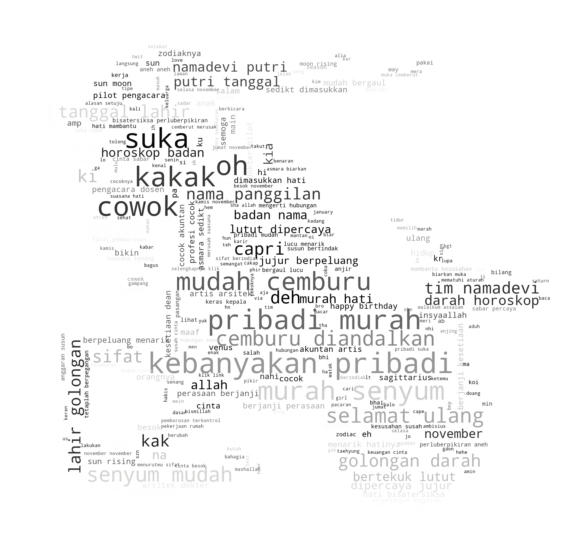

In [ ]:
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)
plt.figure(figsize=(15,10))
my_dpi=960
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.savefig("wordcloud_Capricorn.png",dpi=my_dpi)
files.download("wordcloud_Capricorn.png") 
plt.show()

In [ ]:
wordcloud.to_file("wordcloud_news.png")

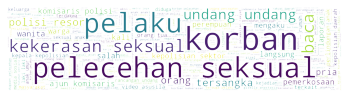

In [ ]:
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("wordcloud_news.png")
plt.show()